In [163]:
import sys
import seaborn as sb
import matplotlib.pyplot as plt 
import numpy as np

In [118]:
# fetch from local path otherwise fetch from the remote path (if remote kernel is being used)
try: 
    sys.path.append('../../scripts')
    import spark
except:
    try:
        sys.path.append('./scripts')
        import spark
    except:
        raise RuntimeError('Failed to import from both local and remote paths. Program terminated.')

# Second Hypothesis
In the following notebook it will be analyzed the following hypothesis:
 - **Can tweet sentiment be predicted more accurately using a machine learning model with the bag of words representation compared to random guessing?**

In [119]:
spark = spark.setup_spark_session(app_name='Hypothesis 2')

In [120]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml.feature import CountVectorizer, Tokenizer
from pyspark.ml.classification import LogisticRegression, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Define the schema
schema = StructType([
    StructField('target', IntegerType(), True),
    StructField('text', StringType(), True),
])

In [121]:
df = spark.read.csv("hdfs://localhost:54310/user/datascience/data/processed/final_tweets_preprocessed", header=False, schema=schema, sep="\t")

In [122]:
df.limit(5).toPandas()

,target,text
0,0,awww that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav im mad cant see


# Bag of Words
The following is the bag of words representation for the given sample corpus.

In [123]:
corpus = [
     (0,'This is the first document'),
     (1,'This document is the second document'),
     (2,'And this is the third one'),
     (3,'Is this the first document'),
]

column = ["id", "text"]
df_corpus = spark.createDataFrame(corpus, column)

tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(df_corpus)

vectorizer = CountVectorizer(inputCol="words", outputCol="bow")
model = vectorizer.fit(wordsData)
result = model.transform(wordsData)

print(f"Vocabulary mapping for the sample corpus: \n {model.vocabulary}")
# Print the dense feature arrays
result.select("bow").toPandas()

Vocabulary mapping for the sample corpus: 
 ['is', 'document', 'the', 'this', 'first', 'second', 'third', 'one', 'and']


,bow
0,"(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
1,"(1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
2,"(1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0)"
3,"(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0)"


Each row in the data frame corresponds to a document in the corpus. The "bow" column contains comma-separated values, each representing a word from the vocabulary.The value at each cell represents the frequency of the word in the corresponding document.

In [124]:
# generate bow for the given dataset
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(df)

vectorizer = CountVectorizer(inputCol="words", outputCol="bow")
model = vectorizer.fit(wordsData)
featuresData = model.transform(wordsData)

print(f"Shape of the bag of words: ({featuresData.select('bow').count()}, {len(model.vocabulary)})")
print(f"Shape of labels: ({featuresData.select('target').count()},)")

Shape of the bag of words: (1591422, 262144)
Shape of labels: (1591422,)


In [125]:
# Create training and test split
featuresData = featuresData.select("bow", "target")
train, test = featuresData.randomSplit([0.9, 0.1], seed=1)
train.limit(5).toPandas()

,bow,target
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


# Logistic Regression
As a base model, we are using logistic regression for the prediction of the tweets.
The suitable value that we determined for the `regparam` (regularization parameter) for this problem is 0.1, after testing different combinations.

In [126]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(featuresCol='bow', labelCol='target', regParam=0.1)

# Fit the model
lr_model = lr.fit(train)
lr_train_accuracy = lr_model.evaluate(train).accuracy
lr_test_accuracy = lr_model.evaluate(test).accuracy

print(f"Train Logisitic Regression accuracy: {(lr_train_accuracy) * 100:.2f}")
print(f"Test Logisitic Regression accuracy: {(lr_test_accuracy) * 100:.2f}")

Train Logisitic Regression accuracy: 82.38
Test Logisitic Regression accuracy: 76.98


Clearly, our base model is predicting the tweets significantly better than the random guessing, which would have produced 50% accuracy.

# SVM
Here we considered more complex model.

The suitable value that we determined for the `regparam` (regularization parameter) for this problem is 0.1, after testing different combinations. We also set the max iterations to be 10, in order to make the training faster.

In [127]:
# Create an instance of SVM classifier
svm = LinearSVC(featuresCol='bow', labelCol='target', regParam=0.1, maxIter=10)

# Fit the model
svm_model = svm.fit(train)

In [128]:
predictions_test = svm_model.transform(test)
predictions_train = svm_model.transform(train)

evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
svm_train_accuracy = evaluator.evaluate(predictions_train)
svm_test_accuracy = evaluator.evaluate(predictions_test)

print(f"Train SVM accuracy: {svm_train_accuracy * 100:.2f}")
print(f"Test SVM accuracy: {svm_test_accuracy * 100:.2f}")

Train SVM accuracy: 82.40
Test SVM accuracy: 77.20


SVM improves the overall accuracy a little bit as compare to Logistic Regression. However, it takes significantly more time in training the model.

# Mutinomial Naive Bayes
For the value of alpha (Laplace smoothing parameter), the suitable value that we determined for this problem is 3, after trying different values.

In [129]:
# Create an instance of Naive Bayes classifier
nb = NaiveBayes(featuresCol='bow', labelCol='target', smoothing=3, modelType='multinomial')

# Fit the model
nb_model = nb.fit(train)

In [130]:
predictions_test = nb_model.transform(test)
predictions_train = nb_model.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")

nb_train_accuracy = evaluator.evaluate(predictions_train)
nb_test_accuracy = evaluator.evaluate(predictions_test)

print(f"Train Naive Bayes accuracy: {nb_train_accuracy * 100:.2f}")
print(f"Test Naive Bayes accuracy: {nb_test_accuracy * 100:.2f}")

Train Naive Bayes accuracy: 78.57
Test Naive Bayes accuracy: 76.95


Multinomial Naive Bayes does not improve the overall accuracy as compare to the SVM and shows slightly lower accuracy than Logistic Regression.

# Best Model
The best model based on the test accuracy is SVM. Using this model, we computed other metrics like precision, recall and f1 score.

In [152]:
accuracies = [lr_test_accuracy, svm_test_accuracy, nb_test_accuracy]
models = [lr_model, svm_model, nb_model]
best_model = models[accuracies.index(max(accuracies))]

predictions = best_model.transform(test)
evaluator_precision = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="f1") 
auc_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")


precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
auc = auc_evaluator.evaluate(predictions)

print(f"Best model: {type(best_model).__name__}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1_score}")
print(f"AUC: {auc}")

Best model: LinearSVCModel
Precision: 0.7721023564765235
Recall: 0.7720254939771105
F1 score: 0.7720151857138976
AUC: 0.7720422429877134


# Confusion Matrix 
In the confusion matrix, we normalized each cell of the matrix by dividing it with the corresponding sum of the row, in order to show the proportion of the correct predictions for each class.

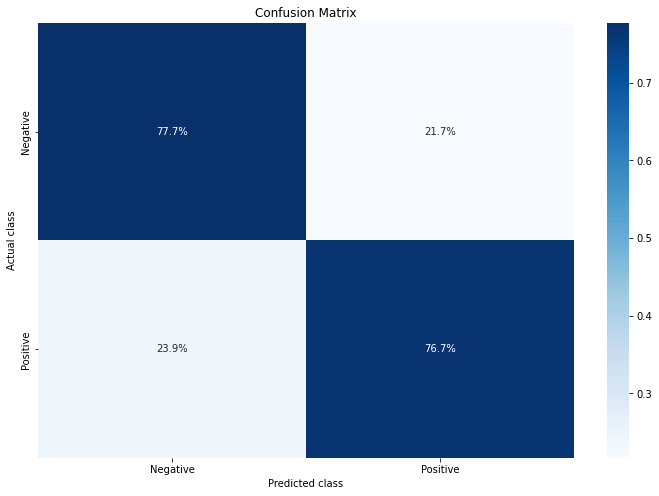

In [165]:
predictions_cfm = predictions.withColumn('target', predictions['target'].cast('double'))
predictions_and_labels = predictions_cfm.select('prediction', 'target').rdd.map(lambda row: (row.prediction, row.target))
metrics = MulticlassMetrics(predictions_and_labels)
cf_matrix = metrics.confusionMatrix().toArray()
plt.figure(figsize = (12,8))
sb.heatmap(cf_matrix/np.sum(cf_matrix, axis=1),
            annot=True, 
            fmt='.1%', 
            cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']).set(xlabel='Predicted class', ylabel='Actual class', title='Confusion Matrix')
plt.show()

In [ ]:
spark.stop()